In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import random
import sys
np.set_printoptions(threshold=sys.maxsize)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y


In [3]:
n = 0
def callback(loss_,loss_lf_,loss_hf_):
    global n
    n += 1
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))

In [4]:
YH1_train = np.genfromtxt('Vis_Train_H.txt')
XH1_train = np.genfromtxt('C01_Train_H.txt')
XH2_train = np.genfromtxt('Sur_Train_H.txt')
XH3_train = np.genfromtxt('Oth_Train_H.txt')
XH4_train = np.genfromtxt('Shr_Train_H.txt')
XH5_train = np.genfromtxt('Age_Train_H.txt')

YH1_train = YH1_train.reshape((-1,1))
XH1_train = XH1_train.reshape((-1,1))
XH2_train = XH2_train.reshape((-1,1))
XH3_train = XH3_train.reshape((-1,1))
XH4_train = XH4_train.reshape((-1,1))
XH5_train = XH5_train.reshape((-1,1))

In [5]:
YH1_test = np.genfromtxt('Vis_Test_H.txt')
XH1_test = np.genfromtxt('C01_Test_H.txt')
XH2_test = np.genfromtxt('Sur_Test_H.txt')
XH3_test = np.genfromtxt('Oth_Test_H.txt')
XH4_test = np.genfromtxt('Shr_Test_H.txt')
XH5_test = np.genfromtxt('Age_Test_H.txt')

YH1_test = YH1_test.reshape((-1,1))
XH1_test = XH1_test.reshape((-1,1))
XH2_test = XH2_test.reshape((-1,1))
XH3_test = XH3_test.reshape((-1,1))
XH4_test = XH4_test.reshape((-1,1))
XH5_test = XH5_test.reshape((-1,1))

In [6]:
YL1_train = np.genfromtxt('Vis_L.txt')
XL1_train = np.genfromtxt('C01_L.txt')
XL2_train = np.genfromtxt('Sur_L.txt')
XL3_train = np.genfromtxt('Oth_L.txt')
XL4_train = np.genfromtxt('Shr_L.txt')
XL5_train = np.genfromtxt('Age_L.txt')

y_lf = ((np.random.normal(1,0.025,len(YL1_train))) * YL1_train).reshape(1,-1).T
x_lf = ((np.random.normal(1,0.025,len(XL1_train))) * XL1_train).reshape(1,-1).T
t_lf = ((np.random.normal(1,0.025,len(XL2_train))) * XL2_train).reshape(1,-1).T
u_lf = ((np.random.normal(1,0.025,len(XL3_train))) * XL3_train).reshape(1,-1).T
w_lf = ((np.random.normal(1,0.025,len(XL4_train))) * XL4_train).reshape(1,-1).T
p_lf = ((np.random.normal(1,0.025,len(XL5_train))) * XL5_train).reshape(1,-1).T

X_lf = np.hstack((x_lf,t_lf,u_lf,w_lf,p_lf))

In [7]:
y_hf = YH1_train.reshape(1,-1).T
x_hf = XH1_train.reshape(1,-1).T
t_hf = XH2_train.reshape(1,-1).T
u_hf = XH3_train.reshape(1,-1).T
w_hf = XH4_train.reshape(1,-1).T
p_hf = XH5_train.reshape(1,-1).T

X_hf = np.hstack((x_hf,t_hf,u_hf,w_hf,p_hf))

Xmin = X_hf.min(0)
Xmax = X_hf.max(0)
Ymin = y_hf.min(0)
Ymax = y_hf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

In [8]:
D = 5
layers_lf = [D] + 2*[20] + [1]
layers_hf_nl = [D+1] + 2*[10] + [1]
layers_hf_l = [D+1] + [1]

x_train_lf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_lf = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x_train_hf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_hf = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [9]:
model = DNN()
W_lf, b_lf = model.hyper_initial(layers_lf)
W_hf_nl, b_hf_nl = model.hyper_initial(layers_hf_nl)
W_hf_l, b_hf_l = model.hyper_initial(layers_hf_l)

y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
#low-fidelity values to serve as the input for the high-fidelity NN
y_pred_lf_hf = model.fnn(W_lf, b_lf, x_train_hf, Xmin, Xmax)
#nonlinear part with two inputs (x_H, y_l(x_H))
y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, tf.concat([x_train_hf, y_pred_lf_hf], 1), Xhmin, Xhmax)
#linear part with two inputs (x_H, y_l(x_H))
y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, tf.concat([x_train_hf, y_pred_lf_hf], 1), Xhmin, Xhmax)
y_pred_hf = y_pred_hf_l + y_pred_hf_nl

In [10]:
loss_l2 = tf.add_n([tf.nn.l2_loss(w_) for w_ in W_hf_nl])
loss_lf = tf.reduce_mean((tf.square(y_pred_lf - y_train_lf)))
loss_hf =  tf.reduce_mean((tf.square(y_pred_hf - y_train_hf)))
loss = loss_lf + loss_hf + loss_l2
train_adam = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
train_lbfgs = ScipyOptimizerInterface(loss,
                                      method = 'L-BFGS-B', 
                                      options={'maxiter': 50000,
                                               'ftol': 1.0*np.finfo(float).eps
                                              })

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### Compile the cell below just only for model loading

In [12]:
#model = saver.restore(sess, 'MPINNModel/MPINNModel')

In [13]:
nmax1 = 2000
nmax2 = 20000
loss_c = 1.0e-6
loss_ = 1.0
train_dict = {x_train_lf: X_lf, y_train_lf: y_lf, x_train_hf: X_hf, y_train_hf: y_hf}
print('Adam Optimizer')
while n < nmax1 and loss_ > loss_c:
    n += 1
    loss_, _, loss_lf_, loss_hf_ = sess.run([loss, train_adam, loss_lf, loss_hf], feed_dict=train_dict)
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))
        saved_path = saver.save(sess, 'MPINNModel/MPINNModel')

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss, loss_lf, loss_hf], loss_callback=callback)

print('Adam Optimizer')
while n < nmax2 and loss_ > loss_c:
    n += 1
    loss_, _, loss_lf_, loss_hf_ = sess.run([loss, train_adam, loss_lf, loss_hf], feed_dict=train_dict)
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))
        saved_path = saver.save(sess, 'MPINNModel/MPINNModel')

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss, loss_lf, loss_hf], loss_callback=callback)
        
print("Training is done!")

Adam Optimizer
n: 1000, loss: 9.928e-02, loss_lf: 9.994e-03, loss_hf: 1.760e-02
n: 2000, loss: 1.074e-02, loss_lf: 4.801e-03, loss_hf: 5.901e-03
LBFG-S Optimizer
n: 3000, loss: 3.906e-03, loss_lf: 1.841e-03, loss_hf: 2.064e-03
n: 4000, loss: 3.010e-03, loss_lf: 1.626e-03, loss_hf: 1.384e-03
n: 5000, loss: 2.770e-03, loss_lf: 1.513e-03, loss_hf: 1.257e-03
n: 6000, loss: 2.635e-03, loss_lf: 1.436e-03, loss_hf: 1.199e-03
n: 7000, loss: 2.561e-03, loss_lf: 1.411e-03, loss_hf: 1.150e-03
n: 8000, loss: 2.508e-03, loss_lf: 1.402e-03, loss_hf: 1.106e-03
n: 9000, loss: 2.447e-03, loss_lf: 1.385e-03, loss_hf: 1.061e-03
n: 10000, loss: 2.406e-03, loss_lf: 1.371e-03, loss_hf: 1.036e-03
n: 11000, loss: 2.372e-03, loss_lf: 1.368e-03, loss_hf: 1.005e-03
n: 12000, loss: 2.350e-03, loss_lf: 1.358e-03, loss_hf: 9.926e-04
n: 13000, loss: 2.313e-03, loss_lf: 1.349e-03, loss_hf: 9.643e-04
n: 14000, loss: 2.290e-03, loss_lf: 1.340e-03, loss_hf: 9.502e-04
n: 15000, loss: 2.255e-03, loss_lf: 1.343e-03, loss_h

In [14]:
x_test_h = XH1_test.reshape((-1, 1))
t_test_h = XH2_test.reshape((-1, 1))
u_test_h = XH3_test.reshape((-1, 1))
w_test_h = XH4_test.reshape((-1, 1))
p_test_h = XH5_test.reshape((-1, 1))

X_test_h = np.hstack((x_test_h,t_test_h,u_test_h,w_test_h,p_test_h))

y_hf_ref = YH1_test.reshape((-1, 1))
y_hf_test = sess.run(y_pred_hf, feed_dict={x_train_hf: X_test_h})

In [29]:
np.savetxt('Results/Y_A_03M.txt', y_hf_ref[84:126])
np.savetxt('Results/Y_M_03M.txt', y_hf_test[84:126])

np.savetxt('Results/Y_A_06M.txt', y_hf_ref[210:252])
np.savetxt('Results/Y_M_06M.txt', y_hf_test[210:252])

np.savetxt('Results/Y_A_09M.txt', y_hf_ref[336:378])
np.savetxt('Results/Y_M_09M.txt', y_hf_test[336:378])

np.savetxt('Results/Y_A_12M.txt', y_hf_ref[462:504])
np.savetxt('Results/Y_M_12M.txt', y_hf_test[462:504])

# Flow Curve 1st Month

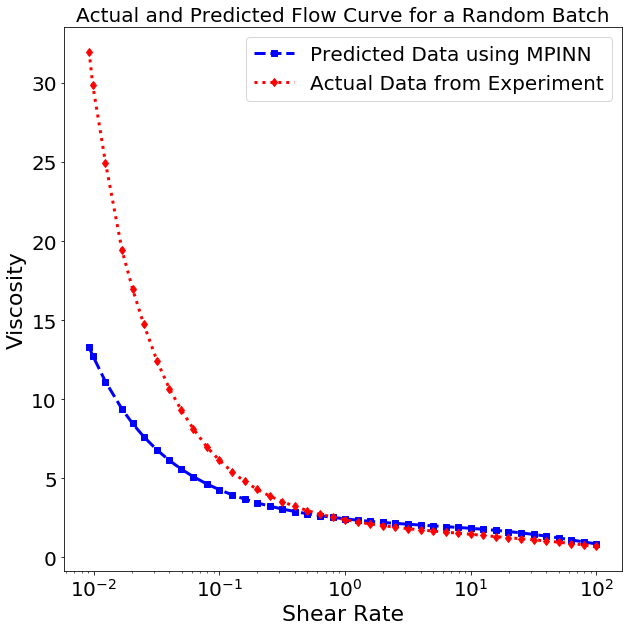

In [15]:
a=0*42
b=1*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 2nd Month

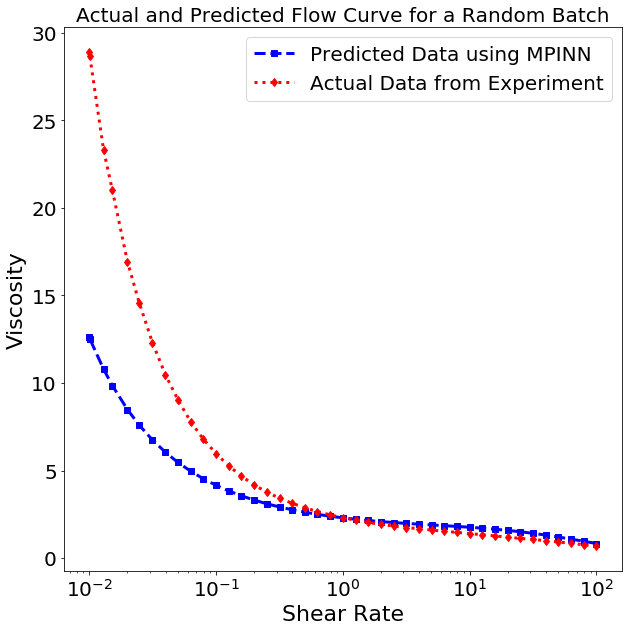

In [16]:
a=1*42
b=2*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 3rd Month

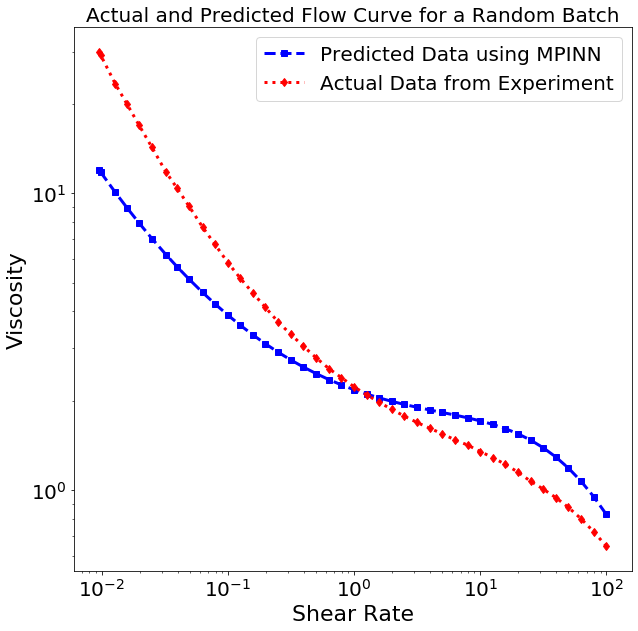

In [17]:
a=2*42
b=3*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Flow Curve 4th Month

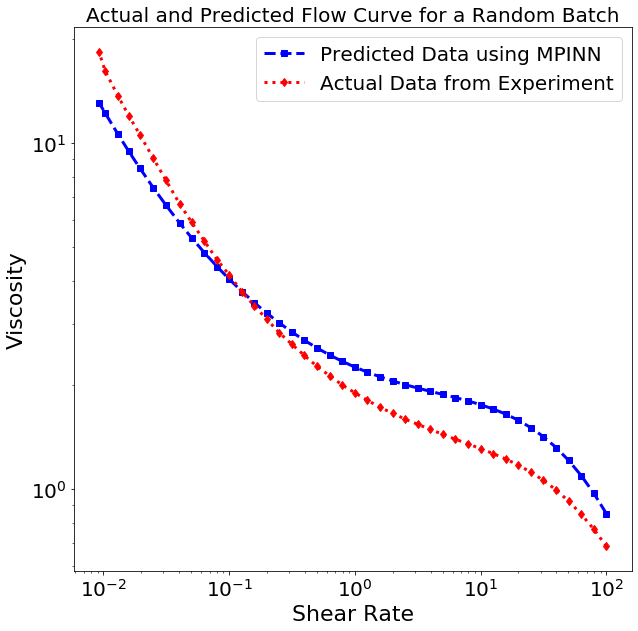

In [18]:
a=3*42
b=4*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Flow Curve 5th Month

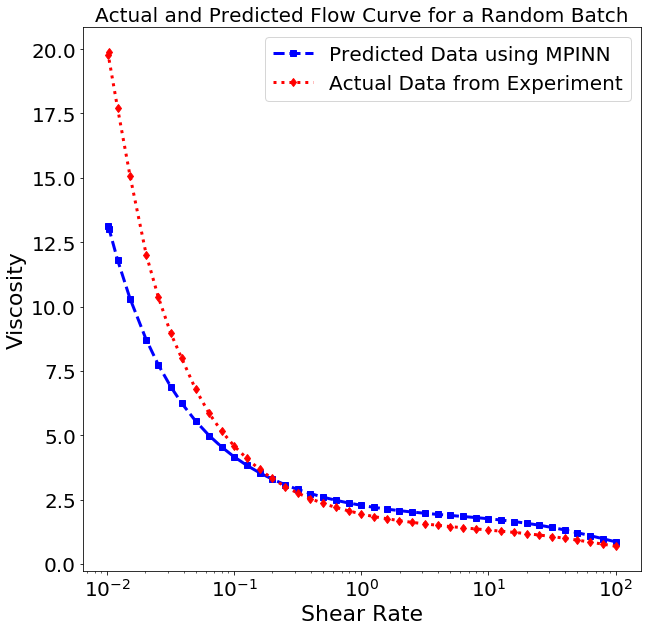

In [19]:
a=4*42
b=5*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 6th Month

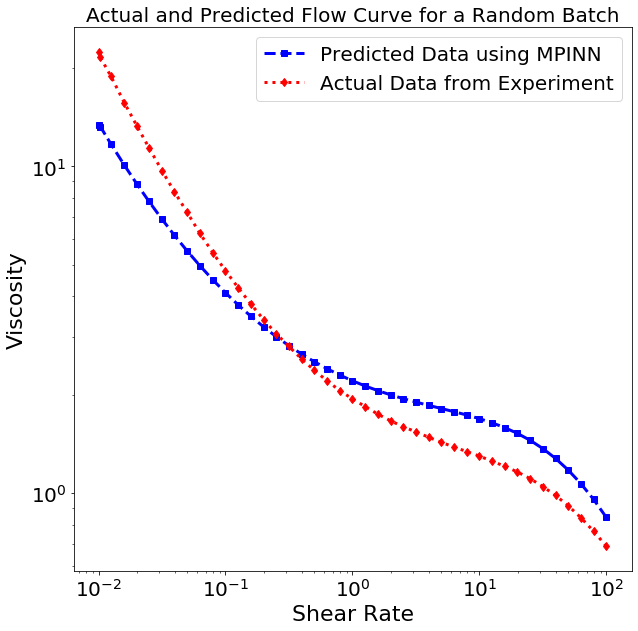

In [20]:
a=5*42
b=6*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Flow Curve 7th Month

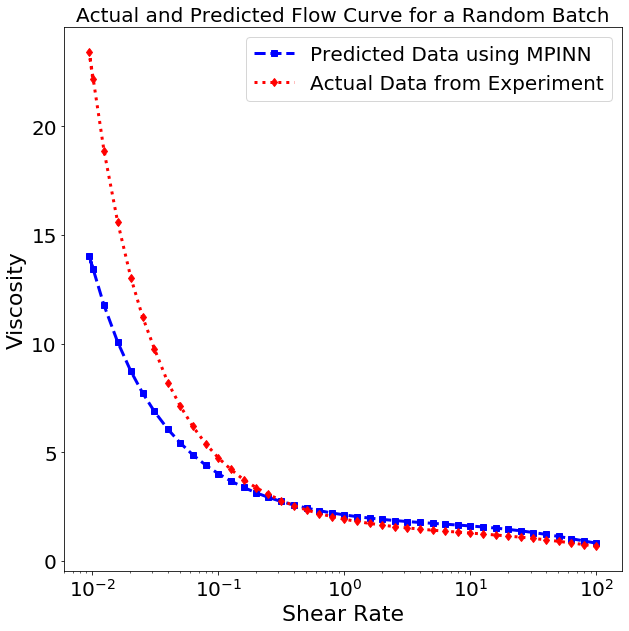

In [21]:
a=6*42
b=7*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 8th Month

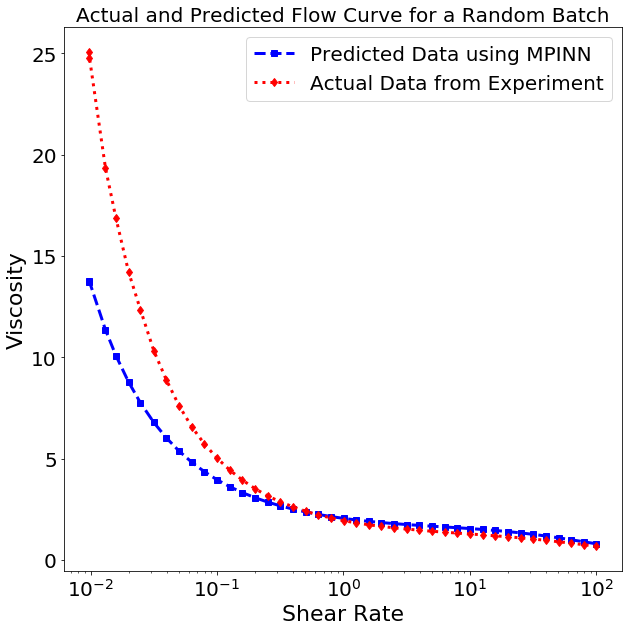

In [22]:
a=7*42
b=8*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 9th Month

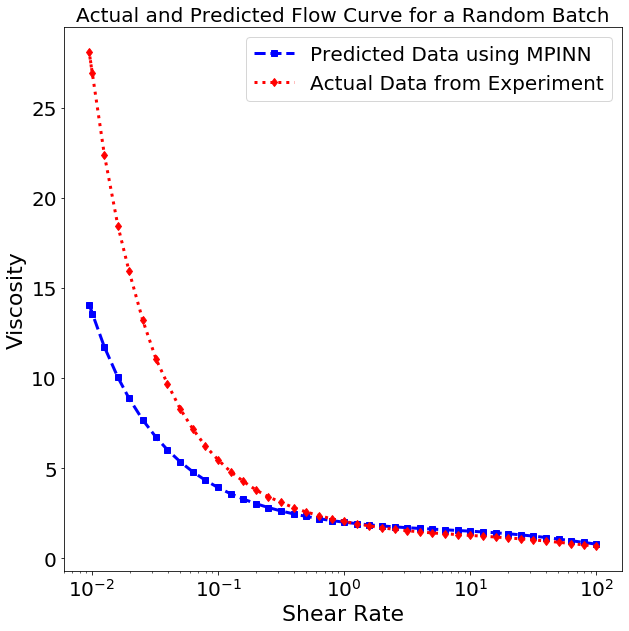

In [23]:
a=8*42
b=9*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 10th Month

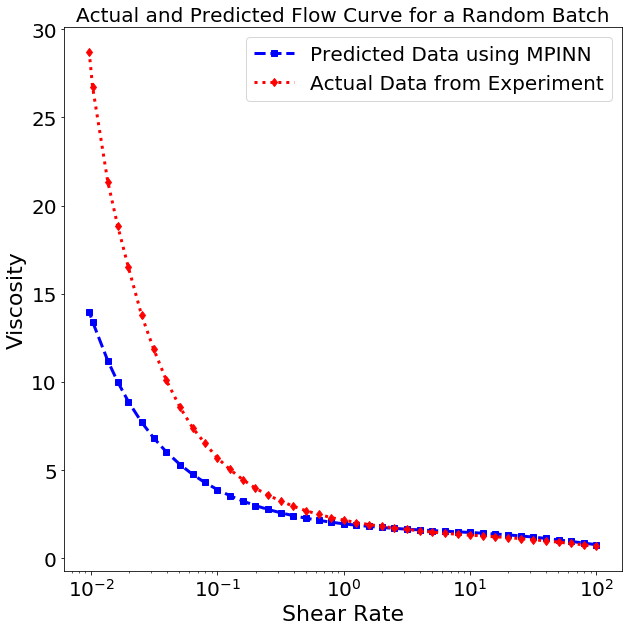

In [24]:
a=9*42
b=10*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 11th Month

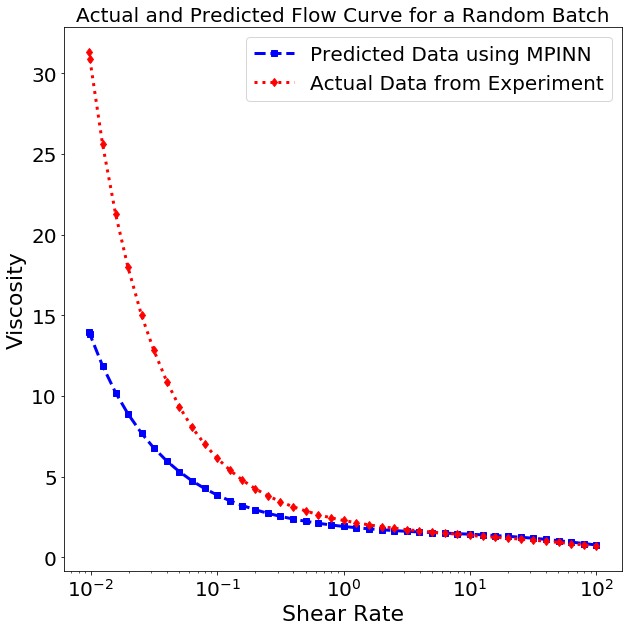

In [25]:
a=10*42
b=11*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")

plt.show()

# Flow Curve 12th Month

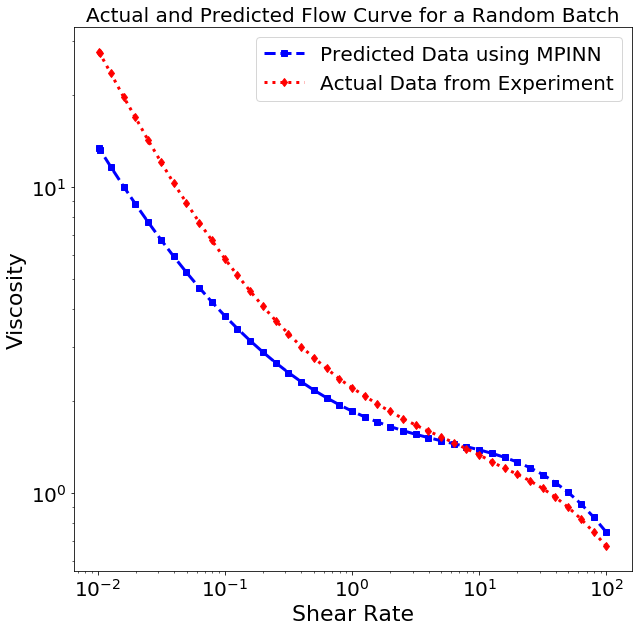

In [26]:
a=11*42
b=12*42

ShR = np.power(10,XH4_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Regression

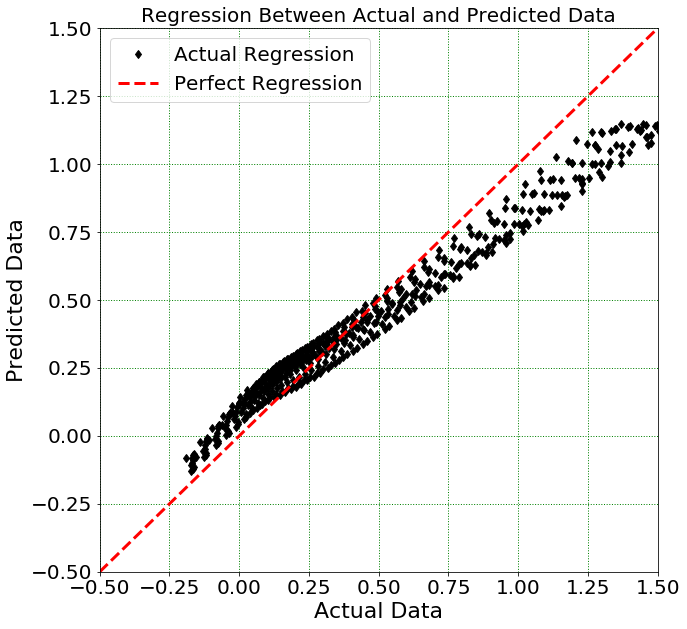

In [27]:
plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(y_hf_ref,y_hf_test, 'kd', linewidth=5.0)
plt.plot(np.linspace(-0.5, 1.5, 100),np.linspace(-0.5, 1.5, 100), 'r--', linewidth=3.0)
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.legend(['Actual Regression','Perfect Regression'])
plt.title('Regression Between Actual and Predicted Data')

plt.grid(color='g', linestyle=':', linewidth=1)

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

#plt.text(-4500, 11500, 'Pearson Regression Correlation is 0.94', style='italic',bbox={'facecolor': 'blue', 'alpha': 0.1, 'pad': 5})
#plt.savefig('00 Research Codes/02_Multi_Fidelity/With_Randy/FX1_linear_regression.png')

plt.show()

# Accuracy

In [28]:
Corr = np.corrcoef(list(y_hf_test.T),list(y_hf_ref.T))[0, 1]

Error = np.sqrt(np.square(y_hf_ref - y_hf_test))
Abs_mean_Error = sum(Error)/len(Error)

mError = 0
aError = 0
for i in range(0,len(y_hf_test)-1):
    a = y_hf_test[i] - y_hf_ref[i]
    b = a/(max(abs(y_hf_test[i]),abs(y_hf_ref[i])))
    c = b**2
    mError = mError + (c)
    aError = aError + abs(a)
mError = 100 * (mError**0.5) / len(y_hf_test)
aError = aError / len(y_hf_test)
print('Mean Absolute Error is :',aError,',And Mean Relative Error is :',mError, ',And Correlation is :',Corr)

#print(np.hstack((y_hf_ref,y_hf_test)))

Mean Absolute Error is : [0.11171958] ,And Mean Relative Error is : [2.07919356] ,And Correlation is : 0.9895627017557562
